# Analytics Project: Kaggle Home Depot Challenge

#### Author: Akshat Gaur
#### AndrewID: agaur

#### Task:

Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

#### Build and iteratively improve a Python-Spark based analytic solution to the Kaggle Home Depot Product Search Relevance Challenge. 

## 1. Create Spark Session

In [2]:
from pyspark.sql import SparkSession
import warnings
warnings.filterwarnings('ignore')
import seaborn

spark = SparkSession.builder.master("local") \
        .appName("Home Depot Challenge") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()


## 2. Read Data from Train, Test, Product Description and Attribute File

#### Train Data:
There are 74067 rows in the train.csv data.
Columns: id, product_uid, product_title, search_term, relevance


#### Test Data:
There are 166693 rows in the test.csv data
Columns: id, product_uid, product_title, search_term

#### Product Description
Contains a text description of each product.
We can join this information togethr with train and test data.

#### Attribute File
Provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product have attributes. This information can also be used with train data.

#### Data fields
<b> id: </b>a unique Id field which represents a (search_term, product_uid) pair <br>
<b> product_uid: </b>an id for the products <br>
<b> product_title: </b>the product title <br>
<b> product_description: </b>the text description of the product (may contain HTML content) <br>
<b> search_term: </b>the search query <br>
<b> relevance: </b>the average of the relevance ratings for a given id <br>
<b> name: </b>an attribute name <br>
<b> value: </b>the attribute's value <br>

In [3]:
from pyspark.sql.types import Row
# from pymongo import MongoClient
from collections import OrderedDict
from pyspark.sql.types import StructField
from pyspark.sql.types import *


train_path = "hdfs://aspen.local:8020/user/agaur/final_project/train.csv"
test_path = "hdfs://aspen.local:8020/user/agaur/final_project/test.csv"
attribute_path = "hdfs://aspen.local:8020/user/agaur/final_project/attributes.csv"
product_description = "hdfs://aspen.local:8020/user/agaur/final_project/product_descriptions.csv"

# create schema
train_schema = StructType([StructField('id', IntegerType(), True), StructField('product_uid', IntegerType(), True),
                    StructField('product_title', StringType(), True), StructField('search_term', StringType(), True),
                           StructField("relevance", DoubleType(), True)])

# Read train data from train.csv and print top 3 rows
train_df = spark.read.format('com.databricks.spark.csv').load(train_path, header=True, schema = train_schema)
print 'Schema:'
train_df.printSchema()
train_df.show(3)

# create schema
test_schema = StructType([StructField('id', IntegerType(), True), StructField('product_uid', IntegerType(), True),
                    StructField('product_title', StringType(), True), StructField('search_term', StringType(), True)])
# Read test data from test.csv and print top 3 rows
test_df = spark.read.format('com.databricks.spark.csv').load(test_path, header = True, schema = test_schema)
print 'Schema:'
test_df.printSchema()
test_df.show(3)

# create schema
attribute_schema = StructType([StructField('product_uid', IntegerType(), True), StructField('name', StringType(), True),
                               StructField('value', StringType(), True)])
# get data from attributes.csv
attribute_df = spark.read.format('com.databricks.spark.csv').load(attribute_path, header = True, schema = attribute_schema)
print 'Schema:'
attribute_df.printSchema()
attribute_df.show(3)

# create schema
product_desc_schema = StructType([StructField('product_uid', IntegerType(), True), 
                                  StructField('product_description', StringType(), True)])
# get data from attributes.csv
product_desc_df = spark.read.format('com.databricks.spark.csv').load(product_description, header = True, schema = product_desc_schema)
print 'Schema:'
product_desc_df.printSchema()
product_desc_df.show(3)

#print count of each file
print 'train count:', train_df.count()
print 'test count:', test_df.count()
print 'attribute count:', attribute_df.count()
print 'product description count:', product_desc_df.count()

Schema:
root
 |-- id: integer (nullable = true)
 |-- product_uid: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- search_term: string (nullable = true)
 |-- relevance: double (nullable = true)

+---+-----------+--------------------+-------------+---------+
| id|product_uid|       product_title|  search_term|relevance|
+---+-----------+--------------------+-------------+---------+
|  2|     100001|Simpson Strong-Ti...|angle bracket|      3.0|
|  3|     100001|Simpson Strong-Ti...|    l bracket|      2.5|
|  9|     100002|BEHR Premium Text...|    deck over|      3.0|
+---+-----------+--------------------+-------------+---------+
only showing top 3 rows

Schema:
root
 |-- id: integer (nullable = true)
 |-- product_uid: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- search_term: string (nullable = true)

+---+-----------+--------------------+-----------------+
| id|product_uid|       product_title|      search_term|
+---+-----------+

## 3. Data Exploration

#### 3.a Test & Train
For both Test and Train:
 1. In the column product_id there are 54667 unique values in train.csv data and 97460 in the test.csv data.
 2. There are total of 27699 product_uid values that are common in both.<br>This information can be visualized using venn diagram shown below

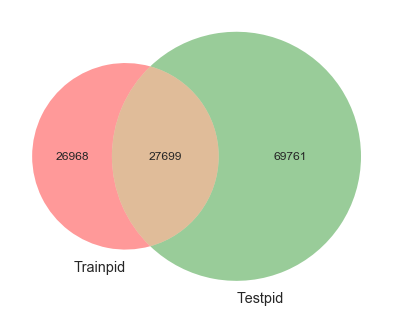

In [4]:
import pandas as pd

train_pdf = train_df.toPandas()
test_pdf = test_df.toPandas()
attribute_pdf = attribute_df.toPandas()
product_desc_pdf = product_desc_df.toPandas()
# train_df.unpersist()
# del test_df
# train_pdf.head()
pidTrain = set(pd.unique(train_pdf['product_uid']))
pidTest = set(pd.unique(test_pdf['product_uid']))
pidatt = set(pd.unique(attribute_pdf['product_uid']))
piddesc = set(pd.unique(product_desc_pdf['product_uid']))
# print pidTrain

# df[['Col1', 'Col2']].values)

# #Count unique *product_uid*, the PK across datasets.
# pidTrain = unique(train_df[product_uid])
# pidTest = unique(test_df[product_uid])
# pidAtt = unique(attribute_df[product_uid])
# pidDesc = unique(product_desc_df[product_uid])

# Create venn diagram to visualize Product IDs in test and train. 

from matplotlib_venn import venn2
import matplotlib.pyplot as plt

venn2([pidTrain, pidTest], ('Trainpid', 'Testpid'))
plt.show()


#### 3.b Test, Train, Attribute and Product Description File

 1. In the attributes.csv file, there are a total of 2044803 rows and a total of 86264 unique product_uid.
 2. There is one value in attributes.csv file that is not present in both the Train or Test files. 
 3. There are 155 rows that do not have a product_uid value. We can remove these while doing data preprocessing.
 4. There are a total of 54667 unique product_uid in the train and 97460 in test. Of these only 27699 are common. The total number of unique product_uids across both the train and test is 124428.

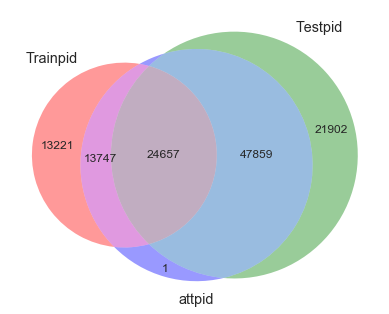

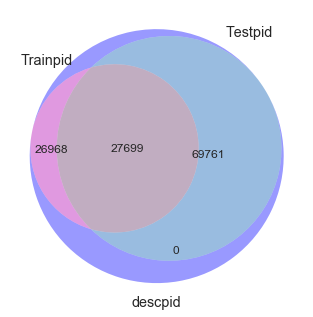

In [5]:
from matplotlib_venn import venn3
# from matplotlib_venn import venn
from matplotlib import pyplot as plt

venn3([pidTrain, pidTest, pidatt], ('Trainpid', 'Testpid', 'attpid'))
plt.show()

venn3([pidTrain, pidTest, piddesc], ('Trainpid', 'Testpid', 'descpid'))
plt.show()

#### 3.c Visualization of Train


1. Relevance Field in train data.
    <br>There are 13 unique values in relevance column of train data. Relevant score that can be given to a product include: Irrelevant (1), Partially or somewhat relevant (2), Perfect match (3).
    <br>From relevance_instructions.docx we can see tath multiple experts give their relevance score from which we finally take mean value so we get these decimal values as final result.
    <br><b>Note:If we remove anamolous values of relevance which are very less and might be noisy data.</b>

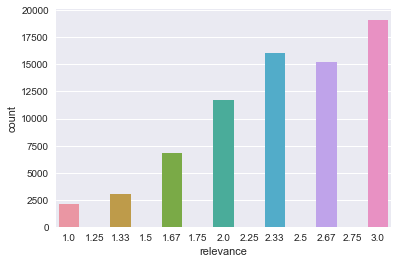

In [6]:
import seaborn as sns
%matplotlib inline

sns.countplot(x='relevance', data=train_pdf)


#### 3.d Visualization of Attribute.csv
1. Attribute file has many attributes for each of the product. These attributes include brand name, material, type, waterproof, etc. Some of these features can provide very useful information about the product but some of them are not of much importance. 
2. Some of the attributes are general information and we can merge them together like all bullet tags or color or color family or brand attributes
3. Some attributes are used by judges to find relevance these include material, functionality,etc.
Attributes from attribute files are important features to train our model as they provide facet data about the product that are generally used in enterprise search. Users generally uses facets search provided by enterprise search engines to get required results. The attribute file contains these facet information about each product. This is the structured meta data provided by enterprise search engine. This data mostly helps the user to search their product once they have initiated the initial query. Based on the initial query, facets are dynamically generated to help the user get precised product. These different facets can act as multiple features for our model to learn. These features can help us in improving precision of our model.
<br>
#### Visualization of Description.csv
Description file provided to us contains general description about each of the product. The information available in description file corresponds to the unstructured meta data stored by enterprise search engines related to their products. This data is helpful in providing suggestions to the user while performing query search. Description file only consists of sentences about each product so we can only get one feature from this file and consider it as BOW feature. This feature can help us in improving the recall of our model.

In [7]:
import numpy as np

# get different types of attributes available
# remove numeric values
attribute_pdf = attribute_pdf.dropna()
idx = np.where(attribute_pdf[['value']].applymap(lambda x: not x.isdigit()))[0]
attribute = attribute_pdf.ix[idx]
attribute.head()


,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


## 4. Data Pre-Processing
Based on the information we gathered by performing data exploration, we can now perform data preprocessing to remove unwanted data and also to clean our data. The data provided to. us in train file is least helpful in performing features enginerring so we need to gather as much information available from other resources to get relevant features.

#### 4.1. Convert data into lower case
The data available to us contains in each of the file is in both cases. We need to convert our data into some specific case in order to avoid mistatch due to different case. In our case the case of the terms is irrelevant and will only reduce the possibility of matching correct results. By converting it into small case I am assuring match irrespective of the case of the terms.

In [8]:
# convert the string data in lower case

train_pdf['product_title'] = train_pdf.product_title.str.lower()
train_pdf['search_term'] = train_pdf.search_term.str.lower()

test_pdf['product_title'] = test_pdf.product_title.str.lower()
test_pdf['search_term'] = test_pdf.search_term.str.lower()

attribute_pdf['name'] = attribute_pdf.name.str.lower()
attribute_pdf['value'] = attribute_pdf.value.str.lower()

product_desc_pdf['product_description'] = product_desc_pdf.product_description.str.lower()

# train_pdf.head()
attribute_pdf.head()

,product_uid,name,value
0,100001.0,bullet01,versatile connector for various 90° connection...
1,100001.0,bullet02,stronger than angled nailing or screw fastenin...
2,100001.0,bullet03,help ensure joints are consistently straight a...
3,100001.0,bullet04,dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,bullet05,made from 12-gauge steel


#### 4.2.  Merge similar attributes of attribute file based on exploration done earlier.

During data exploration we found out that Attributes file contains different facet information about each of the products. These specifications help in distinguishing multiple products and also increasing possibility of a match. Not all the facet information is useful some of them are hardly used by users to perform search. So we can only focus on the attributes that are very common(based on frequency).

In [9]:
# remove null rows from attribute
attribute_pdf = attribute_pdf.dropna()

# combine rows based on product id with multiple brand names
brand_names = attribute_pdf[attribute_pdf['name'].str.contains('brand')][['product_uid', 'value']].rename(columns={"value": "brand"})
brand_names = brand_names.groupby('product_uid')['brand'].apply(' '.join).reset_index()

# combine rows based on product id with multiple bullet names
bullet = attribute_pdf[attribute_pdf['name'].str.contains('bullet')][['product_uid', 'value']].rename(columns={"value": "bullet"})
bullet = bullet.groupby('product_uid')['bullet'].apply(' '.join).reset_index()

# combine rows based on product id with multiple color values
color_family = attribute_pdf[attribute_pdf['name'].str.contains('color family')][['product_uid', 'value']].rename(columns={"value": "color"})
color_finish = attribute_pdf[attribute_pdf['name'].str.contains('color/finish')][['product_uid', 'value']].rename(columns={"value": "color"})
color = pd.concat([color_family, color_finish])
color = color.groupby('product_uid')['color'].apply(' '.join).reset_index()

# combine rows based on product id with multiple material values
material = attribute_pdf[attribute_pdf['name'].str.contains('material') ][['product_uid', 'value']].rename(columns={"value": "material"})
material = material.groupby('product_uid')['material'].apply(' '.join).reset_index()

# combine rows based on product id with multiple function values
function = attribute_pdf[attribute_pdf['name'].str.contains('function')][['product_uid','name', 'value']].rename(columns={"value": "function"})
function = function[function['function'] != 'no'][['product_uid','name', 'function']].reset_index()
idx = list(np.where(function['function'] != 'yes' ))
for x in idx:
    function['name'][x] = function['function'][x]
function = function[['product_uid','name']].rename(columns={"name": "function"})

function = function.groupby('product_uid')['function'].apply(' '.join).reset_index()


In [10]:
# pickle the progress made till now
import pickle

train_pdf.to_pickle('train_pandas')
test_pdf.to_pickle('test_pandas')

#### 4.3. Merge data extracted from attributes and description to train and test

The important attributes that we obtained from attributes.csv file needs to be mearged with the train file coprresponding to the product which it represents. We also get basin description about the product from description file which act as a single feature for our model. We can consider this feature as a bag of word and can use it later for finding similarity.

#### Since a new dataframe is created, we should del older ones and call garbage collector to avoid memory issues.

In [11]:
# Merge brand to train and test

import gc

merged_train = pd.merge(train_pdf, brand_names, on="product_uid", how="left")
merged_train.brand.fillna("unknown", inplace=True)

merged_test = pd.merge(test_pdf, brand_names, on="product_uid", how="left")
merged_test.brand.fillna("unknown", inplace=True)


# Merge color to train and test
# color.info()
merged_train = pd.merge(merged_train, color, on="product_uid", how="left")
merged_train.color.fillna("unknown", inplace=True)

merged_test = pd.merge(merged_test, color, on="product_uid", how="left")
merged_test.color.fillna("unknown", inplace=True)


# Merge bullet to train and test
merged_train = pd.merge(merged_train, bullet, on="product_uid", how="left")
merged_train.bullet.fillna("unknown", inplace=True)

merged_test = pd.merge(merged_test, bullet, on="product_uid", how="left")
merged_test.bullet.fillna("unknown", inplace=True)


# Merge material to train and test
merged_train = pd.merge(merged_train, material, on="product_uid", how="left")
merged_train.material.fillna("unknown", inplace=True)

merged_test = pd.merge(merged_test, material, on="product_uid", how="left")
merged_test.material.fillna("unknown", inplace=True)


# Merge function to train and test
merged_train = pd.merge(merged_train, function, on="product_uid", how="left")
merged_train.function.fillna("unknown", inplace=True)

merged_test = pd.merge(merged_test, function, on="product_uid", how="left")
merged_test.function.fillna("unknown", inplace=True)


#merge product description as well
merged_train = pd.merge(merged_train, product_desc_pdf, on="product_uid", how="left")
merged_test = pd.merge(merged_test, product_desc_pdf, on="product_uid", how="left")

# make relevance the last column
merged_train['relevance'] = merged_train.pop('relevance')

# delete previous dataframes
del train_pdf
del test_pdf
gc.collect()

print merged_test.info()
print merged_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 166693 entries, 0 to 166692
Data columns (total 10 columns):
id                     166693 non-null int64
product_uid            166693 non-null int64
product_title          166693 non-null object
search_term            166693 non-null object
brand                  166693 non-null object
color                  166693 non-null object
bullet                 166693 non-null object
material               166693 non-null object
function               166693 non-null object
product_description    166693 non-null object
dtypes: int64(2), object(8)
memory usage: 14.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74067 entries, 0 to 74066
Data columns (total 11 columns):
id                     74067 non-null int64
product_uid            74067 non-null int64
product_title          74067 non-null object
search_term            74067 non-null object
brand                  74067 non-null object
color                  74067 non-null objec

#### 4.4. Remove anomolies of relevance score from train data

On analysing the relevance score in train.csv, we can see tha some of the relevance score occur very less compared to majority of relevance scores. We do not of consider these entries while training as we do not have much information about these and these might also represent noisy data. 

In [17]:
df = merged_train[['relevance','id']].copy()
df.groupby('relevance').count()

,id
relevance,
1.00,2105
1.25,4
1.33,3006
1.50,5
1.67,6780
1.75,9
2.00,11730
2.25,11
2.33,16060


In [18]:
# Remove relevance score values that were anamolous values

merged_train = merged_train[merged_train.relevance.isin([1.25,1.5,1.75,2.25,2.5,2.75]) == False]
df = merged_train[['relevance','id']].copy()
df.groupby('relevance').count()

,id
relevance,
1.00,2105
1.33,3006
1.67,6780
2.00,11730
2.33,16060
2.67,15202
3.00,19125


#### 4.5 Clean the data
Cleaning the data provided to us is important because The data in train, attribute and description file contains some characters other than letters. All these punctuations, special characters, etc. will reduce the efficiency of our training model. This is because when a user performs search they often query using terms containing letters. Sometimes the query might contain numeric values but its not very often so removing characters other than letters can help improve the model learning. The only character other than letters I am storing is '-'. This is because it lets us know about the coined terms.

In [19]:
import re

merged_train['product_description'] = merged_train['product_description'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['product_title'] = merged_train['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['search_term'] = merged_train['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['brand'] = merged_train['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['bullet'] = merged_train['bullet'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['color'] = merged_train['color'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['material'] = merged_train['material'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_train['function'] = merged_train['function'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)

merged_test['product_description'] = merged_test['product_description'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['product_title'] = merged_test['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['search_term'] = merged_test['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['brand'] = merged_test['product_title'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['bullet'] = merged_test['bullet'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['color'] = merged_test['color'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['material'] = merged_test['material'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)
merged_test['function'] = merged_test['function'].apply(lambda x: re.split(r"[^\w-]+",' '.join(x.split()))).apply(' '.join)


In [20]:
# pickle data
merged_train.to_pickle('cleaned_train')
merged_test.to_pickle('cleaned_test')


In [21]:
# read from cleaned files
merged_train = pd.read_pickle('cleaned_train')
merged_test = pd.read_pickle('cleaned_test')


In [22]:
print merged_train.info()
print merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74008 entries, 0 to 74066
Data columns (total 11 columns):
id                     74008 non-null int64
product_uid            74008 non-null int64
product_title          74008 non-null object
search_term            74008 non-null object
brand                  74008 non-null object
color                  74008 non-null object
bullet                 74008 non-null object
material               74008 non-null object
function               74008 non-null object
product_description    74008 non-null object
relevance              74008 non-null float64
dtypes: float64(1), int64(2), object(8)
memory usage: 6.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 166693 entries, 0 to 166692
Data columns (total 10 columns):
id                     166693 non-null int64
product_uid            166693 non-null int64
product_title          166693 non-null object
search_term            166693 non-null object
brand                  166693 non-nul

#### 4.4. Handle Typos in the search term of train and test
There are very high chances of making spelling mistakes/Typos while querying for a product. This is very common among humans. Almost 13% of the search terms provided to us contain Typos (cited from information provided on kaggle). To take into considerations human errors we need to consider typing errors made while performing product search.

In [23]:
from spelling_checker_dict import spelling_checker_dict

# This dictionary was available on kaggle site where it was shared under kernel for this particular task.
# Convert the data present in the dictionary to lower case.
spelling_checker_dict = dict((k.lower() if isinstance(k, basestring) else k, v.lower() if isinstance(v, basestring) else v) for k,v in spelling_checker_dict.iteritems())

merged_train['search_term'] = merged_train['search_term'].replace(spelling_checker_dict)
merged_test['search_term'] = merged_test['search_term'].replace(spelling_checker_dict)
    

In [29]:
# pickle data after typos are handled
merged_train.to_pickle('typos_train')
merged_test.to_pickle('typos_test')


In [30]:
print merged_train.info()
print merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74008 entries, 0 to 74066
Data columns (total 11 columns):
id                     74008 non-null int64
product_uid            74008 non-null int64
product_title          74008 non-null object
search_term            74008 non-null object
brand                  74008 non-null object
color                  74008 non-null object
bullet                 74008 non-null object
material               74008 non-null object
function               74008 non-null object
product_description    74008 non-null object
relevance              74008 non-null float64
dtypes: float64(1), int64(2), object(8)
memory usage: 6.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 166693 entries, 0 to 166692
Data columns (total 10 columns):
id                     166693 non-null int64
product_uid            166693 non-null int64
product_title          166693 non-null object
search_term            166693 non-null object
brand                  166693 non-nul

In [31]:
# read stored data
merged_train = pd.read_pickle('typos_train')
merged_test = pd.read_pickle('typos_test')

#### 4.6. Stop word removal from train and test
Some of the attributes extracted from the attribute file contains information in form of sentences. This is also true in the case of description file. All such features contain some word that do not provide any meaningful information for training the model. These words often occur and will result into wrong estimation of features like overlap, tf-idf, ratio of match, etc. All these stop words can be removed before calculating any similarity based features. I will be using NLTK corpus stopwords vocab for cleaning the data.

In [32]:
# used nltk corpus english stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

merged_train['product_title'] = merged_train['product_title'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_train['bullet'] = merged_train['bullet'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_train['product_description'] = merged_train['product_description'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_train['brand'] = merged_train['brand'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_train['function'] = merged_train['function'].apply(lambda x: [item for item in x.split() if item not in stop])

merged_test['product_title'] = merged_test['product_title'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_test['bullet'] = merged_test['bullet'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_test['product_description'] = merged_test['product_description'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_test['brand'] = merged_test['brand'].apply(lambda x: [item for item in x.split() if item not in stop])
merged_test['function'] = merged_test['function'].apply(lambda x: [item for item in x.split() if item not in stop])


In [33]:
# pickle the data
merged_train.to_pickle('stop_train')
merged_test.to_pickle('stop_test')

In [50]:
# read stored data
merged_train = pd.read_pickle('stop_train')
merged_test = pd.read_pickle('stop_test')

In [51]:
merged_train.head(2)
# print merged_test.head(2)

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance
0,2,100001,"[simpson, strong-tie, 12-gauge, angle]",simpson strong-tie 12-gauge angle,"[simpson, strong-tie, 12-gauge, angle]",unknown,"[versatile, connector, various, 90, connection...",galvanized steel,[unknown],"[angles, make, joints, stronger, also, provide...",3.0
2,9,100002,"[behr, premium, textured, deckover, 1-gal, sc-...",behr premium textured deckover 1-gal sc-141 tu...,"[behr, premium, textured, deckover, 1-gal, sc-...",browns tans tugboat,"[revives, wood, composite, decks, railings, po...",unknown,[unknown],"[behr, premium, textured, deckover, innovative...",3.0


In [52]:
# join the list created after removing stop words for each feature
merged_train['product_title'] = merged_train['product_title'].apply(' '.join)
merged_train['product_description'] = merged_train['product_description'].apply(' '.join)
# merged_train['search_term'] = merged_train['search_term'].apply(' '.join)
# merged_train['material'] = merged_train['material'].apply(' '.join)
# merged_train['color'] = merged_train['color'].apply(' '.join)
merged_train['bullet'] = merged_train['bullet'].apply(' '.join)
merged_train['brand'] = merged_train['brand'].apply(' '.join)
merged_train['function'] = merged_train['function'].apply(' '.join)

merged_test['product_title'] = merged_test['product_title'].apply(' '.join)
merged_test['product_description'] = merged_test['product_description'].apply(' '.join)
merged_test['bullet'] = merged_test['bullet'].apply(' '.join)
merged_test['brand'] = merged_test['brand'].apply(' '.join)
merged_test['function'] = merged_test['function'].apply(' '.join)
# merged_test['search_term'] = merged_test['search_term'].apply(' '.join)
# merged_test['material'] = merged_test['material'].apply(' '.join)
# merged_test['color'] = merged_test['color'].apply(' '.join)



In [53]:
merged_train.head(5)
# print merged_test.head(4)

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance
0,2,100001,simpson strong-tie 12-gauge angle,simpson strong-tie 12-gauge angle,simpson strong-tie 12-gauge angle,unknown,versatile connector various 90 connections hom...,galvanized steel,unknown,angles make joints stronger also provide consi...,3.00
2,9,100002,behr premium textured deckover 1-gal sc-141 tu...,behr premium textured deckover 1-gal sc-141 tu...,behr premium textured deckover 1-gal sc-141 tu...,browns tans tugboat,revives wood composite decks railings porches ...,unknown,unknown,behr premium textured deckover innovative soli...,3.00
3,16,100005,delta vero 1-handle shower faucet trim kit chr...,delta vero 1-handle shower only faucet trim ki...,delta vero 1-handle shower faucet trim kit chr...,chrome chrome,includes trim kit rough-in kit r10000-unbx sol...,unknown,unknown,update bathroom delta vero single-handle showe...,2.33
4,17,100005,delta vero 1-handle shower faucet trim kit chr...,delta vero 1-handle shower only faucet trim ki...,delta vero 1-handle shower faucet trim kit chr...,chrome chrome,includes trim kit rough-in kit r10000-unbx sol...,unknown,unknown,update bathroom delta vero single-handle showe...,2.67
5,18,100006,whirlpool 1 9 cu ft range convection microwave...,whirlpool 1 9 cu ft over the range convection ...,whirlpool 1 9 cu ft range convection microwave...,stainless steel stainless,spacious 1 9 cu ft capacity accommodates dinne...,unknown,unknown,achieving delicious results almost effortless ...,3.00


 ##### 4.7.  Stem train and test
 
 In our enterprise environment, user can use any of the derivation generated from the root word to match the product. It's highly likely that the user uses some terms which mean the same as a product but still do not match the term used to present that product. To avoid such senarios we need to stem the data to root word to improve the match results. Since we are performing stemming these root words might not be actual words. We can also perform lemmatization instead of stemming. The reason I chose stemming is because our environment does not have information data where lemmatization is more important and here we are not looking for true meaning of the word. Also lemmatization takes more time to perform cleaning compared to stemming.

In [54]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

merged_train['product_title'] = merged_train['product_title'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['product_description']= merged_train['product_description'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['search_term'] = merged_train['search_term'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['bullet'] = merged_train['bullet'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['brand'] = merged_train['brand'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['color'] = merged_train['color'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['material'] = merged_train['material'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_train['function'] = merged_train['function'].apply(lambda x: [stemmer.stem(y) for y in x.split()])

merged_test['product_title'] = merged_test['product_title'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['product_description']= merged_test['product_description'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['search_term'] = merged_test['search_term'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['bullet'] = merged_test['bullet'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['brand'] = merged_test['brand'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['color'] = merged_test['color'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['function'] = merged_test['function'].apply(lambda x: [stemmer.stem(y) for y in x.split()])
merged_test['material'] = merged_test['material'].apply(lambda x: [stemmer.stem(y) for y in x.split()])


In [55]:
# pickle the stemmed data
merged_train.to_pickle('stemmed_train')
merged_test.to_pickle('stemmed_test')

In [56]:
merged_train = pd.read_pickle('stemmed_train')
merged_test = pd.read_pickle('stemmed_test')

In [59]:
print merged_train.info()
merged_train.head()
# merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74008 entries, 0 to 74066
Data columns (total 11 columns):
id                     74008 non-null int64
product_uid            74008 non-null int64
product_title          74008 non-null object
search_term            74008 non-null object
brand                  74008 non-null object
color                  74008 non-null object
bullet                 74008 non-null object
material               74008 non-null object
function               74008 non-null object
product_description    74008 non-null object
relevance              74008 non-null float64
dtypes: float64(1), int64(2), object(8)
memory usage: 6.8+ MB
None


,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance
0,2,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",3.00
2,9,100002,"[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[brown, tan, tugboat]","[reviv, wood, composit, deck, rail, porch, boa...",[unknown],[unknown],"[behr, premium, textur, deckov, innov, solid, ...",3.00
3,16,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.33
4,17,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.67
5,18,100006,"[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[whirlpool, 1, 9, cu, ft, over, the, rang, con...","[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[stainless, steel, stainless]","[spacious, 1, 9, cu, ft, capac, accommod, dinn...",[unknown],[unknown],"[achiev, delici, result, almost, effortless, w...",3.00


#### 4.8. Tokenize train and test data

To perform all similarity based operations we need to tokenize the data available. If we consider the whole string for similarity then we will skip most of search terms that match the information we have. In order to perform matching properly we need to convert our data into BOW.

In [60]:
# all features are already tokenised during stemming
# merged_train['color'] = merged_train['color'].apply(lambda x: x.split())
merged_train.head()

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance
0,2,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",3.00
2,9,100002,"[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[brown, tan, tugboat]","[reviv, wood, composit, deck, rail, porch, boa...",[unknown],[unknown],"[behr, premium, textur, deckov, innov, solid, ...",3.00
3,16,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.33
4,17,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.67
5,18,100006,"[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[whirlpool, 1, 9, cu, ft, over, the, rang, con...","[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[stainless, steel, stainless]","[spacious, 1, 9, cu, ft, capac, accommod, dinn...",[unknown],[unknown],"[achiev, delici, result, almost, effortless, w...",3.00


## 5. Feature Engineering

#### 5.1. Add length features for search term and product related features.
Length of features like description, attributes can be very useful. This is because we have removed stop words and higher the length more are the chances of match with the search term. Thus length feature of these features will help us analyse if the size of description or other attributes will increase the possibility of match or not. Features on which length might be helpful include: search term, product title, product description and bullet. Only these features have significant information to consider length as a feature.

In [65]:
merged_train['len_search_term'] = merged_train['search_term'].map(lambda x: len(x))
merged_train['len_product_title'] = merged_train['product_title'].map(lambda x: len(x))
merged_train['len_product_description'] = merged_train['product_description'].map(lambda x: len(x))
# merged_train['len_brand'] = merged_train['brand'].map(lambda x: len(x))
merged_train['len_bullet'] = merged_train['bullet'].map(lambda x: len(x))
# merged_train['len_function'] = merged_train['function'].map(lambda x: len(x))


merged_test['len_search_term'] = merged_test['search_term'].map(lambda x: len(x))
merged_test['len_product_title'] = merged_test['product_title'].map(lambda x: len(x))
merged_test['len_product_description'] = merged_test['product_description'].map(lambda x: len(x))
# merged_test['len_brand'] = merged_test['brand'].map(lambda x: len(x))
merged_test['len_bullet'] = merged_test['bullet'].map(lambda x: len(x))
# merged_test['len_function'] = merged_test['function'].map(lambda x: len(x))


In [79]:
# # meged_train = merged_train[['']]
# drop_col = ['len_brand', 'len_function']
# # merged_train = merged_train.drop(drop_col, axis=1)
# merged_test = merged_test.drop(drop_col, axis=1)
# # print merged_train.info()
# merged_test.head()

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,len_search_term,len_product_title,len_product_description,len_bullet,match_color
0,1,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",4,4,86,45,0.0
1,4,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",4,4,86,45,0.0
2,5,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",4,4,86,45,0.0
3,6,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",4,4,86,45,0.0
4,7,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",4,4,86,45,0.0


#### 5.2. Add boolean feature for color match
Color match in itself can not be a important feature because we need to match the product first. But once the product is matched, color match of the product with the color provided in query tells us if the results retrieved are relevant or not. So color is very helpful feature to decide relevancy once we find some overlap of search term with our data. This feature will help in training when used with features like overlap.

In [63]:
def color_match(st, colors):
    for color in st:
        if color in colors:
            return True
    return False

merged_train['match_color'] = merged_train.apply(lambda x: color_match(x['search_term'], x['color']), axis=1).astype(np.float)
merged_test['match_color'] = merged_test.apply(lambda x: color_match(x['search_term'], x['color']), axis=1).astype(np.float)

#### 5.3. Create features based on Edit distance

Edit distance tell is how well the a term matches with other term. Edit distance is very commonly used metric to perform similarity check. Edit distance was used as an important feature to decide the the similarity of search term with features like description, title, attributes, etc. My assumption is lesser the value of edit distance higher are the chance of results to be relevant.
This feature did not provide much useful insight while learning and took much time for generation still I used it in final features as it provides some useful information.

In [82]:
from nltk.metrics import edit_distance

# calculate min edit distance of product title product description with search terms

# find min edit distance
def get_edit_distance(row, col):
    dists = [min([edit_distance(w, x) for x in row[col]]) for w in row['search_term']]
    return (min(dists), sum(dists))


# find edit distance of product title
merged_train['edit_dist_product_title'] = merged_train.apply(lambda x: get_edit_distance(x, 'product_title'), axis=1)
merged_train['edit_dist_product_title_min'] = merged_train['edit_dist_product_title'].map(lambda x: x[0])
merged_train['edit_dist_product_title_avg'] = merged_train['edit_dist_product_title'].map(lambda x: x[1]) / merged_train['len_search_term']                                                             

merged_test['edit_dist_product_title'] = merged_test.apply(lambda x: get_edit_distance(x, 'product_title'), axis=1)
merged_test['edit_dist_product_title_min'] = merged_test['edit_dist_product_title'].map(lambda x: x[0])
merged_test['edit_dist_product_title_avg'] = merged_test['edit_dist_product_title'].map(lambda x: x[1]) / merged_test['len_search_term']                                                             


# find edit distance of product description
# merged_train['edit_dist_product_description'] = merged_train.apply(lambda x: get_edit_distance(x, 'product_description'), axis=1)
# merged_train['edit_dist_product_description_min'] = merged_train['edit_dist_product_description'].map(lambda x: x[0])
# merged_train['edit_dist_product_description_avg'] = merged_train['edit_dist_product_title'].map(lambda x: x[1]) / merged_train['len_search_term']                                                             

# merged_test['edit_dist_product_description'] = merged_test.apply(lambda x: get_edit_distance(x, 'product_description'), axis=1)
# merged_test['edit_dist_product_description_min'] = merged_test['edit_dist_product_description'].map(lambda x: x[0])
# merged_test['edit_dist_product_description_avg'] = merged_test['edit_dist_product_description'].map(lambda x: x[1]) / merged_test['len_search_term']                                                             

merged_train.drop(['edit_dist_product_title'], axis=1, inplace=True)
merged_test.drop(['edit_dist_product_title'], axis=1, inplace=True)


In [83]:
merged_train.head()
# print merged_test.info()

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance,len_search_term,len_product_title,len_product_description,len_bullet,match_color,edit_dist_product_title_min,edit_dist_product_title_avg
0,2,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",3.00,4,4,86,45,0.0,0,0.000000
2,9,100002,"[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[brown, tan, tugboat]","[reviv, wood, composit, deck, rail, porch, boa...",[unknown],[unknown],"[behr, premium, textur, deckov, innov, solid, ...",3.00,11,10,120,80,1.0,0,0.272727
3,16,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.33,13,10,68,38,1.0,0,0.538462
4,17,100005,"[delta, vero, 1-handl, shower, faucet, trim, k...","[delta, vero, 1-handl, shower, onli, faucet, t...","[delta, vero, 1-handl, shower, faucet, trim, k...","[chrome, chrome]","[includ, trim, kit, rough-in, kit, r10000-unbx...",[unknown],[unknown],"[updat, bathroom, delta, vero, single-handl, s...",2.67,13,10,68,38,1.0,0,0.538462
5,18,100006,"[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[whirlpool, 1, 9, cu, ft, over, the, rang, con...","[whirlpool, 1, 9, cu, ft, rang, convect, micro...","[stainless, steel, stainless]","[spacious, 1, 9, cu, ft, capac, accommod, dinn...",[unknown],[unknown],"[achiev, delici, result, almost, effortless, w...",3.00,16,12,316,245,1.0,0,0.750000


In [84]:
# # store train and test updated file
merged_train.to_pickle('edit_dis_train')
merged_test.to_pickle('edit_dis_test')

In [85]:
# # read train and test file from csv

merged_train = pd.read_pickle('edit_dis_train')
merged_test = pd.read_pickle('edit_dis_test')

# print merged_train.info()
# print merged_test.info()

In [87]:
merged_train.head(2)
# print merged_test.head(2)

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,relevance,len_search_term,len_product_title,len_product_description,len_bullet,match_color,edit_dist_product_title_min,edit_dist_product_title_avg
0,2,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",3.0,4,4,86,45,0.0,0,0.000000
2,9,100002,"[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[brown, tan, tugboat]","[reviv, wood, composit, deck, rail, porch, boa...",[unknown],[unknown],"[behr, premium, textur, deckov, innov, solid, ...",3.0,11,10,120,80,1.0,0,0.272727


#### 5.4. Create boolean features for a match in search term 
I used a flag feature to store 1/0 value if any term in search query matches any term in a particular feature. Search queries are generally short in size so the words used to represent information need of the user are highly specific. If any of these terms match with the meta information we have about the product, then the chance of product being relevant increases. 

In [88]:
merged_train['flag_st_pt'] = merged_train.apply(lambda x: int(x['search_term'] in x['product_title']), axis=1)
merged_train['flag_st_pd'] = merged_train.apply(lambda x: int(x['search_term'] in x['product_description']), axis=1)
merged_train['flag_st_br'] = merged_train.apply(lambda x: int(x['search_term'] in x['brand']), axis=1)
merged_train['flag_st_bl'] = merged_train.apply(lambda x: int(x['search_term'] in x['bullet']), axis=1)
merged_train['flag_st_mt'] = merged_train.apply(lambda x: int(x['search_term'] in x['material']), axis=1)
merged_train['flag_st_fn'] = merged_train.apply(lambda x: int(x['search_term'] in x['function']), axis=1)

merged_test['flag_st_pt'] = merged_test.apply(lambda x: int(x['search_term'] in x['product_title']), axis=1)
merged_test['flag_st_pd'] = merged_test.apply(lambda x: int(x['search_term'] in x['product_description']), axis=1)
merged_test['flag_st_br'] = merged_test.apply(lambda x: int(x['search_term'] in x['brand']), axis=1)
merged_test['flag_st_bl'] = merged_test.apply(lambda x: int(x['search_term'] in x['bullet']), axis=1)
merged_test['flag_st_mt'] = merged_test.apply(lambda x: int(x['search_term'] in x['material']), axis=1)
merged_test['flag_st_fn'] = merged_test.apply(lambda x: int(x['search_term'] in x['function']), axis=1)

#### 5.5. Create features to find overlap of search terms
Another feature that can provide insight about the relevance is how much the information provided in meta data is overlapping/matching with the search terms. This feature is somewhat similar to the bollean feature but here instead of storing boolean values we are taking into consideration the count of terms that matched.

In [89]:
merged_train['num_st_pt'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['product_title']))), axis=1)
merged_train['num_st_pd'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['product_description']))), axis=1)
merged_train['num_st_br'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['brand']))), axis=1)
merged_train['num_st_bl'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['bullet']))), axis=1)
merged_train['num_st_mt'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['material']))), axis=1)
merged_train['num_st_fn'] = merged_train.apply(lambda x: len(set(x['search_term']).intersection(set(x['function']))), axis=1)

merged_test['num_st_pt'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['product_title']))), axis=1)
merged_test['num_st_pd'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['product_description']))), axis=1)
merged_test['num_st_br'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['brand']))), axis=1)
merged_test['num_st_bl'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['bullet']))), axis=1)
merged_test['num_st_mt'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['material']))), axis=1)
merged_test['num_st_fn'] = merged_test.apply(lambda x: len(set(x['search_term']).intersection(set(x['function']))), axis=1)



In [90]:
merged_train.head(2)

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,...,flag_st_br,flag_st_bl,flag_st_mt,flag_st_fn,num_st_pt,num_st_pd,num_st_br,num_st_bl,num_st_mt,num_st_fn
0,2,100001,"[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]","[simpson, strong-ti, 12-gaug, angl]",[unknown],"[versatil, connector, various, 90, connect, ho...","[galvan, steel]",[unknown],"[angl, make, joint, stronger, also, provid, co...",...,0,0,0,0,4,4,4,2,0,0
2,9,100002,"[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[behr, premium, textur, deckov, 1-gal, sc-141,...","[brown, tan, tugboat]","[reviv, wood, composit, deck, rail, porch, boa...",[unknown],[unknown],"[behr, premium, textur, deckov, innov, solid, ...",...,0,0,0,0,10,7,10,5,0,0


#### 5.6. Create features for search term match ratio

This is another feature that considers the numbers of terms matched between search term feature and other features. In this feature we consider the proportion of search term that matches with our features. I have considered multiple features based on similarity of term with some differences because in this task user will generally use smaller queries to search for products and count of matching terms is the most important feature to calculate relevancy of results produced.

In [91]:
merged_train['ratio_st_pt'] = merged_train.apply(lambda x: x['num_st_pt'] / float(x['len_search_term']), axis=1)
merged_train['ratio_st_pd'] = merged_train.apply(lambda x: x['num_st_pd'] / float(x['len_search_term']), axis=1)
merged_train['ratio_st_br'] = merged_train.apply(lambda x: x['num_st_br'] / float(x['len_search_term']), axis=1)
merged_train['ratio_st_bl'] = merged_train.apply(lambda x: x['num_st_bl'] / float(x['len_search_term']), axis=1)
merged_train['ratio_st_mt'] = merged_train.apply(lambda x: x['num_st_mt'] / float(x['len_search_term']), axis=1)
merged_train['ratio_st_fn'] = merged_train.apply(lambda x: x['num_st_fn'] / float(x['len_search_term']), axis=1)

merged_test['ratio_st_pt'] = merged_test.apply(lambda x: x['num_st_pt'] / float(x['len_search_term']), axis=1)
merged_test['ratio_st_pd'] = merged_test.apply(lambda x: x['num_st_pd'] / float(x['len_search_term']), axis=1)
merged_test['ratio_st_br'] = merged_test.apply(lambda x: x['num_st_br'] / float(x['len_search_term']), axis=1)
merged_test['ratio_st_bl'] = merged_test.apply(lambda x: x['num_st_bl'] / float(x['len_search_term']), axis=1)
merged_test['ratio_st_mt'] = merged_test.apply(lambda x: x['num_st_mt'] / float(x['len_search_term']), axis=1)
merged_test['ratio_st_fn'] = merged_test.apply(lambda x: x['num_st_fn'] / float(x['len_search_term']), axis=1)


In [92]:
merged_train.to_pickle('ratio_train')
merged_test.to_pickle('ratio_test')

In [93]:
# join the list created 
# For the rest of the features I used I will be considering the data as a single string first 
# in order to perform my reformations on the features.
merged_train['product_title'] = merged_train['product_title'].apply(' '.join)
merged_train['product_description'] = merged_train['product_description'].apply(' '.join)
merged_train['search_term'] = merged_train['search_term'].apply(' '.join)
merged_train['bullet'] = merged_train['bullet'].apply(' '.join)
merged_train['brand'] = merged_train['brand'].apply(' '.join)
merged_train['material'] = merged_train['material'].apply(' '.join)
merged_train['function'] = merged_train['function'].apply(' '.join)

merged_test['product_title'] = merged_test['product_title'].apply(' '.join)
merged_test['product_description'] = merged_test['product_description'].apply(' '.join)
merged_test['search_term'] = merged_test['search_term'].apply(' '.join)
merged_test['bullet'] = merged_test['bullet'].apply(' '.join)
merged_test['brand'] = merged_test['brand'].apply(' '.join)
merged_test['material'] = merged_test['material'].apply(' '.join)
merged_test['function'] = merged_test['function'].apply(' '.join)

In [95]:
# merged_train.head(2)
merged_test.head(2)


,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,...,num_st_br,num_st_bl,num_st_mt,num_st_fn,ratio_st_pt,ratio_st_pd,ratio_st_br,ratio_st_bl,ratio_st_mt,ratio_st_fn
0,1,100001,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,[unknown],versatil connector various 90 connect home rep...,galvan steel,unknown,angl make joint stronger also provid consist s...,...,4,2,0,0,1.0,1.0,1.0,0.5,0.0,0.0
1,4,100001,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,[unknown],versatil connector various 90 connect home rep...,galvan steel,unknown,angl make joint stronger also provid consist s...,...,4,2,0,0,1.0,1.0,1.0,0.5,0.0,0.0


#### 5.7. Create Count Vectorizer (BOW)

For the next features I generated I considered the information available as BOW (bag of word). Count vectorizer is used to create a vector with all the terms that appeared in the data. This approach will help me in considering the data as BOW. Once I get a vector to represent each term I used similarity metric to find how much the query terms are similar to the features available. To perform this similarity check I used cosine similarity metric.

In [99]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english', max_features=1000)
frames = [merged_train, merged_test]
df = pd.concat(frames)
cv.fit(df['search_term'] + ' ' + df['product_title'] + ' ' + df['product_description'] + ' ' + df['bullet'] + ' ' + df['brand']+ ' ' + df['material']+ ' ' + df['function'])

del df

cv_train_st = cv.transform(merged_train['search_term'])
cv_train_pt = cv.transform(merged_train['product_title'])
cv_train_pd = cv.transform(merged_train['product_description'])
cv_train_br = cv.transform(merged_train['brand'])
cv_train_bl = cv.transform(merged_train['bullet'])
cv_train_mt = cv.transform(merged_train['material'])
cv_train_fn = cv.transform(merged_train['function'])


cv_test_st = cv.transform(merged_test['search_term'])
cv_test_pt = cv.transform(merged_test['product_title'])
cv_test_pd = cv.transform(merged_test['product_description'])
cv_test_br = cv.transform(merged_test['brand'])
cv_test_bl = cv.transform(merged_test['bullet'])
cv_test_mt = cv.transform(merged_test['material'])
cv_test_fn = cv.transform(merged_test['function'])


#### 5.8. Find cosine similarity for above count vectors w.r.t Search Term
Once I generate a count vector to represent each term in my corpus, I now create features based on the cosine similarity of search term with other features. To create cosine similarity based features I used sklearn inbuilt metric.

In [100]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim_train_st_pt = [cosine_similarity(cv_train_st[i], cv_train_pt[i])[0][0] for i in range(cv_train_st.shape[0])]
cos_sim_train_st_pd = [cosine_similarity(cv_train_st[i], cv_train_pd[i])[0][0] for i in range(cv_train_st.shape[0])]
cos_sim_train_st_br = [cosine_similarity(cv_train_st[i], cv_train_br[i])[0][0] for i in range(cv_train_st.shape[0])]
cos_sim_train_st_bl = [cosine_similarity(cv_train_st[i], cv_train_bl[i])[0][0] for i in range(cv_train_st.shape[0])]
cos_sim_train_st_mt = [cosine_similarity(cv_train_st[i], cv_train_mt[i])[0][0] for i in range(cv_train_st.shape[0])]
cos_sim_train_st_fn = [cosine_similarity(cv_train_st[i], cv_train_fn[i])[0][0] for i in range(cv_train_st.shape[0])]

cos_sim_test_st_pt = [cosine_similarity(cv_test_st[i], cv_test_pt[i])[0][0] for i in range(cv_test_st.shape[0])]
cos_sim_test_st_pd = [cosine_similarity(cv_test_st[i], cv_test_pd[i])[0][0] for i in range(cv_test_st.shape[0])]
cos_sim_test_st_br = [cosine_similarity(cv_test_st[i], cv_test_br[i])[0][0] for i in range(cv_test_st.shape[0])]
cos_sim_test_st_bl = [cosine_similarity(cv_test_st[i], cv_test_bl[i])[0][0] for i in range(cv_test_st.shape[0])]
cos_sim_test_st_mt = [cosine_similarity(cv_test_st[i], cv_test_mt[i])[0][0] for i in range(cv_test_st.shape[0])]
cos_sim_test_st_fn = [cosine_similarity(cv_test_st[i], cv_test_fn[i])[0][0] for i in range(cv_test_st.shape[0])]


merged_train['cos_sim_st_pt'] = cos_sim_train_st_pt
merged_train['cos_sim_st_pd'] = cos_sim_train_st_pd
merged_train['cos_sim_st_br'] = cos_sim_train_st_br
merged_train['cos_sim_st_bl'] = cos_sim_train_st_bl
merged_train['cos_sim_st_mt'] = cos_sim_train_st_mt
merged_train['cos_sim_st_fn'] = cos_sim_train_st_fn

merged_test['cos_sim_st_pt'] = cos_sim_test_st_pt
merged_test['cos_sim_st_pd'] = cos_sim_test_st_pd
merged_test['cos_sim_st_br'] = cos_sim_test_st_br
merged_test['cos_sim_st_bl'] = cos_sim_test_st_bl
merged_test['cos_sim_st_mt'] = cos_sim_test_st_mt
merged_test['cos_sim_st_fn'] = cos_sim_test_st_fn

In [101]:
merged_train.to_pickle('cos_sim_train')
merged_test.to_pickle('cos_sim_test')

In [102]:
merged_train = pd.read_pickle('cos_sim_train')
merged_test = pd.read_pickle('cos_sim_test')

#### 5.9. Use Tf-Idf
Tf-idf is an important feature and different from other features mentioned above as many of them do not take into consideration the feature length. While calculating tf-idf we consider the feature length and penalise a feature if its length is big. This is important as there are high chances of match if the feature size is bigger but this does not always imply that feature is more relevant. So considering these features will improve the efficiency.

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

frames = [merged_test, merged_test]
df = pd.concat(frames)

tfv = TfidfVectorizer(ngram_range=(1, 3), stop_words='english', max_features=1000)
tfv.fit(df['search_term'] + ' ' + df['product_title'] + ' ' + df['product_description'] + ' ' + df['bullet'] + ' ' + df['brand']+ ' ' + df['material']+ ' ' + df['function'])
del df

tfv_train_st = tfv.transform(merged_train['search_term'])
tfv_train_pt = tfv.transform(merged_train['product_title'])
tfv_train_pd = tfv.transform(merged_train['product_description'])
tfv_train_bl = tfv.transform(merged_train['bullet'])
tfv_train_br = tfv.transform(merged_train['brand'])
tfv_train_mt = tfv.transform(merged_train['material'])
tfv_train_fn = tfv.transform(merged_train['function'])

tfv_test_st = tfv.transform(merged_test['search_term'])
tfv_test_pt = tfv.transform(merged_test['product_title'])
tfv_test_pd = tfv.transform(merged_test['product_description'])
tfv_test_bl = tfv.transform(merged_test['bullet'])
tfv_test_br = tfv.transform(merged_test['brand'])
tfv_test_mt = tfv.transform(merged_test['material'])
tfv_test_fn = tfv.transform(merged_test['function'])

In [105]:
tfv_train_st_pt = [cosine_similarity(tfv_train_st[i], tfv_train_pt[i])[0][0] for i in range(tfv_train_st.shape[0])]
tfv_train_st_pd = [cosine_similarity(tfv_train_st[i], tfv_train_pd[i])[0][0] for i in range(tfv_train_st.shape[0])]
tfv_train_st_bl = [cosine_similarity(tfv_train_st[i], tfv_train_bl[i])[0][0] for i in range(tfv_train_st.shape[0])]
tfv_train_st_br = [cosine_similarity(tfv_train_st[i], tfv_train_br[i])[0][0] for i in range(tfv_train_st.shape[0])]
tfv_train_st_mt = [cosine_similarity(tfv_train_st[i], tfv_train_mt[i])[0][0] for i in range(tfv_train_st.shape[0])]
tfv_train_st_fn = [cosine_similarity(tfv_train_st[i], tfv_train_fn[i])[0][0] for i in range(tfv_train_st.shape[0])]

tfv_test_st_pt = [cosine_similarity(tfv_test_st[i], tfv_test_pt[i])[0][0] for i in range(tfv_test_st.shape[0])]
tfv_test_st_pd = [cosine_similarity(tfv_test_st[i], tfv_test_pd[i])[0][0] for i in range(tfv_test_st.shape[0])]
tfv_test_st_bl = [cosine_similarity(tfv_test_st[i], tfv_test_bl[i])[0][0] for i in range(tfv_test_st.shape[0])]
tfv_test_st_br = [cosine_similarity(tfv_test_st[i], tfv_test_br[i])[0][0] for i in range(tfv_test_st.shape[0])]
tfv_test_st_mt = [cosine_similarity(tfv_test_st[i], tfv_test_mt[i])[0][0] for i in range(tfv_test_st.shape[0])]
tfv_test_st_fn = [cosine_similarity(tfv_test_st[i], tfv_test_fn[i])[0][0] for i in range(tfv_test_st.shape[0])]


merged_train['tfv_st_pt'] = tfv_train_st_pt
merged_train['tfv_st_pd'] = tfv_train_st_pd
merged_train['tfv_st_bl'] = tfv_train_st_bl
merged_train['tfv_st_br'] = tfv_train_st_br
merged_train['tfv_st_mt'] = tfv_train_st_mt
merged_train['tfv_st_fn'] = tfv_train_st_fn

merged_test['tfv_st_pt'] = tfv_test_st_pt
merged_test['tfv_st_pd'] = tfv_test_st_pd
merged_test['tfv_st_bl'] = tfv_test_st_bl
merged_test['tfv_st_br'] = tfv_test_st_br
merged_test['tfv_st_mt'] = tfv_test_st_mt
merged_test['tfv_st_fn'] = tfv_test_st_fn


In [106]:
merged_train.head(2)
# merged_test.head(2)

,id,product_uid,product_title,search_term,brand,color,bullet,material,function,product_description,...,cos_sim_st_br,cos_sim_st_bl,cos_sim_st_mt,cos_sim_st_fn,tfv_st_pt,tfv_st_pd,tfv_st_bl,tfv_st_br,tfv_st_mt,tfv_st_fn
0,2,100001,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,simpson strong-ti 12-gaug angl,[unknown],versatil connector various 90 connect home rep...,galvan steel,unknown,angl make joint stronger also provid consist s...,...,1.0,0.416667,0.0,0.0,1.0,0.397726,0.424676,1.0,0.0,0.0
2,9,100002,behr premium textur deckov 1-gal sc-141 tugboa...,behr premium textur deckov 1-gal sc-141 tugboa...,behr premium textur deckov 1-gal sc-141 tugboa...,"[brown, tan, tugboat]",reviv wood composit deck rail porch boat dock ...,unknown,unknown,behr premium textur deckov innov solid color c...,...,1.0,0.320513,0.0,0.0,1.0,0.466927,0.295880,1.0,0.0,0.0


In [107]:
merged_train.to_pickle('tf_train')
merged_test.to_pickle('tf_test')

In [8]:
merged_train = pd.read_pickle('tf_train')
merged_test = pd.read_pickle('tf_test')

#### 5.10 Brand Encoding
Brnad is very significant aspect when searching for a product. Many a times user direclty query a product using the brand/ manufacturer name. Thus considering brand is highly important. Since brand is a non -numeric feature so I performed encoding on this feature to get numeric feature.

In [9]:
df = pd.concat([merged_train,merged_test])
all_brand = pd.unique(df.brand.ravel())
new_brand = {}
encode = 0
for brand in all_brand:
    new_brand[brand] = encode
    encode += 1
new_brand['unknown'] = encode

merged_train['brand_encoding'] = merged_train['brand'].map(lambda x: new_brand.get(x, -1))
merged_test['brand_encoding'] = merged_test['brand'].map(lambda x: new_brand.get(x, -1))

In [10]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74008 entries, 0 to 74066
Data columns (total 49 columns):
id                             74008 non-null int64
product_uid                    74008 non-null int64
product_title                  74008 non-null object
search_term                    74008 non-null object
brand                          74008 non-null object
color                          74008 non-null object
bullet                         74008 non-null object
material                       74008 non-null object
function                       74008 non-null object
product_description            74008 non-null object
relevance                      74008 non-null float64
len_search_term                74008 non-null int64
len_product_title              74008 non-null int64
len_product_description        74008 non-null int64
len_bullet                     74008 non-null int64
match_color                    74008 non-null float64
edit_dist_product_title_min    74008 non-null i

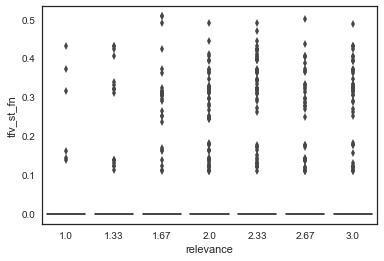

In [21]:
sns.boxplot(x='relevance', y='tfv_st_fn', data=merged_train)

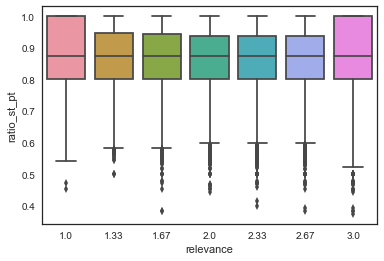

In [22]:
sns.boxplot(x='relevance', y='ratio_st_pt', data=merged_train)

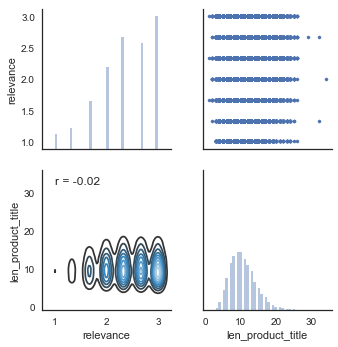

In [29]:
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")

df = pd.DataFrame(merged_train, columns=["relevance", "len_product_title"])

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df, palette=["red"])
g.map_upper(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)
plt.show()

## 6. Create DF with final features

In [126]:
# print merged_train.info()
# print merged_test.head()
# merged_train['relevance'] = train_pdf['relevance']
feat_list = ['id', 'product_uid', \
             'len_search_term', 'len_product_title', 'len_product_description', 'len_bullet',\
             'match_color', 'brand_encoding',\
             'edit_dist_product_title_min', 'edit_dist_product_title_avg', \
             'cos_sim_st_pt', 'cos_sim_st_pd', 'cos_sim_st_br', 'cos_sim_st_bl', 'cos_sim_st_mt', 'cos_sim_st_fn',\
             'tfv_st_pt', 'tfv_st_pd', 'tfv_st_br', 'tfv_st_bl', 'tfv_st_mt', 'tfv_st_fn',
             'flag_st_pt', 'flag_st_pd', 'flag_st_br', 'flag_st_bl', 'flag_st_mt', 'flag_st_fn', \
             'num_st_pt', 'num_st_pd', 'num_st_br', 'num_st_bl', 'num_st_mt', 'num_st_fn', \
             'ratio_st_pt', 'ratio_st_pd', 'ratio_st_br', 'ratio_st_bl', 'ratio_st_mt', 'ratio_st_fn', \
             'relevance']
train = merged_train[feat_list]
feat_list.remove('relevance')
test = merged_test[feat_list]
# print train_pdf.info()
print train.info()
print test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74008 entries, 0 to 74066
Data columns (total 41 columns):
id                             74008 non-null int64
product_uid                    74008 non-null int64
len_search_term                74008 non-null int64
len_product_title              74008 non-null int64
len_product_description        74008 non-null int64
len_bullet                     74008 non-null int64
match_color                    74008 non-null float64
brand_encoding                 74008 non-null int64
edit_dist_product_title_min    74008 non-null int64
edit_dist_product_title_avg    74008 non-null float64
cos_sim_st_pt                  74008 non-null float64
cos_sim_st_pd                  74008 non-null float64
cos_sim_st_br                  74008 non-null float64
cos_sim_st_bl                  74008 non-null float64
cos_sim_st_mt                  74008 non-null float64
cos_sim_st_fn                  74008 non-null float64
tfv_st_pt                      74008 non-nu

## 7. Use Pyspark

In [127]:
from pyspark.sql.functions import col
# from pyspark.sql import SparkSession

# spark1 = SparkSession.builder.master("local") \
#         .appName("Home Depot Challenge") \
#         .config("spark.some.config.option", "some-value") \
#         .getOrCreate()


train.to_csv('final_train.csv', index = False)
spark_train = spark.read.csv('./final_train.csv', header = True)
# spark_train.printSchema()

test.to_csv('final_test.csv', index = False)
spark_test = spark.read.csv('./final_test.csv', header = True)
# spark_test.printSchema()

col_names = [(i, 'double') for i in spark_train.schema.names if not i == 'id']
col_names.append(('id', 'string'))
exprs = [col(i).cast(v) for i,v in col_names]
spark_train = spark_train.select(*exprs)

col_names = [(i, 'double') for i in spark_test.schema.names if not i == 'id']
col_names.append(('id', 'string'))
exprs = [col(i).cast(v) for i,v in col_names]
spark_test = spark_test.select(*exprs)
spark_train.printSchema()
# spark_test.printSchema()



root
 |-- product_uid: double (nullable = true)
 |-- len_search_term: double (nullable = true)
 |-- len_product_title: double (nullable = true)
 |-- len_product_description: double (nullable = true)
 |-- len_bullet: double (nullable = true)
 |-- match_color: double (nullable = true)
 |-- brand_encoding: double (nullable = true)
 |-- edit_dist_product_title_min: double (nullable = true)
 |-- edit_dist_product_title_avg: double (nullable = true)
 |-- cos_sim_st_pt: double (nullable = true)
 |-- cos_sim_st_pd: double (nullable = true)
 |-- cos_sim_st_br: double (nullable = true)
 |-- cos_sim_st_bl: double (nullable = true)
 |-- cos_sim_st_mt: double (nullable = true)
 |-- cos_sim_st_fn: double (nullable = true)
 |-- tfv_st_pt: double (nullable = true)
 |-- tfv_st_pd: double (nullable = true)
 |-- tfv_st_br: double (nullable = true)
 |-- tfv_st_bl: double (nullable = true)
 |-- tfv_st_mt: double (nullable = true)
 |-- tfv_st_fn: double (nullable = true)
 |-- flag_st_pt: double (nullable = 

#### 7.1 Use Pyspark Assembler

In [182]:
from pyspark.ml.feature import VectorAssembler

#assemble all features togwether
assembler = VectorAssembler(
            inputCols = [x for x in spark_train.columns if x != 'relevance' and x != 'id'],
            outputCol = 'features')

assembler_df = assembler.transform(spark_train)

#### 7.2 PCA

Many features were created during feature engineering. Some of them might be similar and provide redundant information. Some might not have high correlation with the labels. To reduce the dimentionality of features I will use PCA.

In [190]:
# from pyspark.ml.feature import PCA
pca = PCA(k=10, inputCol="features", outputCol="pca_features")
model = pca.fit(assembler_df)

## 8.1 Using Random Forest Regressor Model

In [191]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

rf = RandomForestRegressor(featuresCol="features", labelCol = 'relevance')


#### 8.1.1 Create Pipeline

In [192]:
# create a pipeline

pipeline_rf = Pipeline(stages = [
    assembler, 
    rf,
])


#### 8.1.2 Use ParamGrid for parameter tuning 

In [193]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [15, 25, 50]) \
    .addGrid(rf.featureSubsetStrategy,['auto', 'sqrt'] )\
    .build()

#### 8.1.3 Perform Cross validation

In [194]:
from pyspark.ml.evaluation import RegressionEvaluator

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=RegressionEvaluator(labelCol='relevance', predictionCol="prediction"),
                          numFolds=5)

#### 8.1.4 Create train model

In [195]:
model_rf = crossval_rf.fit(spark_train)
# spark_train.printSchema()

#### 8.1.5 Transform Test and predict labels

In [166]:
# predictions
predictions_rf = model_rf.transform(spark_test)
predictions_rf.select('prediction', 'features').show(10)


+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3689124699544406|(39,[0,1,2,3,4,9,...|
|2.3264243425199083|(39,[0,1,2,3,4,5,...|
|2.3264243425199083|(39,[0,1,2,3,4,5,...|
|2.3264243425199083|(39,[0,1,2,3,4,5,...|
|2.3779782413115313|(39,[0,1,2,3,4,6,...|
+------------------+--------------------+
only showing top 10 rows



#### 8.1.6 Store the Predictions

In [169]:
result_rf = predictions_rf.select('id', 'prediction').withColumnRenamed('prediction', 'relevance')
df_rf = result_rf.toPandas()
df_rf.to_csv('result_rf.csv', index = False)


## 8.2 Linear Regressor Model

In [171]:
from pyspark.ml.regression import LinearRegression

# Build the model
lr = LinearRegression(featuresCol="features", labelCol="relevance", predictionCol="prediction", max_iter=5)


model_lr = pipeline_lr.fit(spark_train)
# spark_train.show()



#### 8.2.1 Create Pipeline

In [172]:
# create a pipeline

pipeline_lr = Pipeline(stages = [
    assembler, 
    lr,
])

#### 8.2.2 Use ParamGrid for parameter tuning 

In [173]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.standardization,[True, False] )\
    .build()

#### 8.2.3 Perform Cross validation

In [174]:
from pyspark.ml.evaluation import RegressionEvaluator

crossval_lr = CrossValidator(estimator=pipeline_lr,
                          estimatorParamMaps=paramGrid_lr,
                          evaluator=RegressionEvaluator(labelCol='relevance', predictionCol="prediction"),
                          numFolds=5)

#### 8.2.4 Create train model

In [175]:
model_lr = crossval_lr.fit(spark_train)
# spark_train.printSchema()

#### 8.2.5 Transform Test and predict labels

In [176]:
# predictions
predictions_lr = model_lr.transform(spark_test)
predictions_lr.select('prediction', 'features').show(10)


+------------------+--------------------+
|        prediction|            features|
+------------------+--------------------+
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
| 2.371202060247362|(39,[0,1,2,3,4,9,...|
|2.5347924835383546|(39,[0,1,2,3,4,5,...|
|2.5347924835383546|(39,[0,1,2,3,4,5,...|
|2.5347924835383546|(39,[0,1,2,3,4,5,...|
| 2.700453920636984|(39,[0,1,2,3,4,6,...|
+------------------+--------------------+
only showing top 10 rows



#### 8.2.6 Store the Predictions

In [180]:
result_lr = predictions_lr.select('id', 'prediction').withColumnRenamed('prediction', 'relevance')
df_lr = result_lr.toPandas()
for i,x in enumerate(df_lr['relevance']):
    if x < 1:
        df_lr['relevance'][i] = 1
        print 'i'
    elif df_lr['relevance'][i] > 3:
        print 'ii'
        df_lr['relevance'][i] = 3
df_lr.to_csv('result_lr.csv', index = False)

ii


## 9. Discussion on Models:

As per the task we were supposed to provide the relevance score given a search term. If we consider the acceptable values of relevance score then this task looks like classification problem as only three values can be assigned for relevance. But this is not true. If we read the relevance judgement file, we can see that more than one person is considered for judging the relevance of results of train data. To give the final relevance score mean is taken of all the scores provided by judges. If we analyse this then we can say that this is a regression problem as taking mean of relevance score can result into multiple values. Some of these will not be available in the train data set. This is one of the major reason why this is not a classification problem as in classification problem the classification set for test is a subset of train classification set.

Two models that I used to perform prediction include Random Forest Regressor and Linear Regression Model. AS per my kaggle score the Random Forest Regressor performed better on this data set.

For performing feature Selection I used basically two approaches:
<br>Used seaborn plots to understand the correlation between feature and relevance score.
<br>Also used PCA to find relevant feature and reduced redundant features.



##### KAGGLE SCORE:
##### RFR : 0.52274
##### LR: 0.52516

![title](result.png)

## 10. Conclusion


##### What I learnt:
In coming up with a solution for this project, I learnt how a search analysis is performed. How to study and analyse user behavior. I learnt how to use pyspark from training our model. How we can completely put everything in pipeline and how we can test the hyperparameters and come up with the best result.

##### What you could have done more:
For this task, I also wanted to try some other similarity metrics like Jaccard similarity, use some features based on type of product and finally I could have used ensemble learning to try to use multi-level modelling to improve my model and to make it more stable. I also wanted to more analyse and explain the plots that I used to come up with features. Query expansion is one more thing that could be applied.

##### Challenges Faced:
I faced some challenges in feature engineering. Some features required lot of time for generation. Some other issues I faced was on applying ensemble method because of which I was not able to finally finish it. 

##### Innovative Techniques Used:
Found a new library seaborn which is highly useful in analysis of data while performing data exploration. It can be useful in plotting the data for better picturization of the same.

##### Results:
Getting a high accuracy in enterprise search environment is pretty difficult, especially if user data is not available. If we have user data then we can use personalization to improve the results. 


## 11. Citation
#### For data exploration and feature engineering I used below links for reference. Some part of my approach was also provided in these links. 
https://www.kaggle.com/briantc/home-depot-product-search-relevance/homedepot-first-dataexploreation-k 

https://www.kaggle.com/tennissuperstar/home-depot-product-search-relevance/data-exploration-1

https://github.com/dnc1994/Kaggle-Playground/blob/master/home-depot/Preprocess.ipynb